In [14]:
import numpy as np
import pandas as pd
import torch
from importlib.metadata import version
import re
import tiktoken
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn as nn
import matplotlib.pyplot as plt

In [15]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) 
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [16]:
linear_layer = nn.Linear(5, 6)
relu = torch.nn.ReLU()

output = relu(linear_layer(batch_example))
output

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [17]:
print("before mean:", batch_example.mean(dim=1))
print("before variance:", batch_example.var(dim=1, unbiased=False))
print("after mean:", output.mean(dim=1))
print("after variance:", output.var(dim=1, unbiased=False))

before mean: tensor([-0.3596, -0.2606])
before variance: tensor([0.2015, 0.2673])
after mean: tensor([0.1324, 0.2170], grad_fn=<MeanBackward1>)
after variance: tensor([0.0192, 0.0332], grad_fn=<VarBackward0>)


In [18]:
means = output.mean(dim=-1, keepdim=True)  # Shape: (2, 1)
variances = output.var(dim=-1, keepdim=True, unbiased=False)  # Shape: (2, 1)

# Normalize the output
normalized = (output - means) / torch.sqrt(variances)
normalized

tensor([[ 0.6746,  1.5474, -0.9551,  0.6433, -0.9551, -0.9551],
        [-0.0207,  0.1228, -1.1915,  1.6621,  0.6186, -1.1915]],
       grad_fn=<DivBackward0>)

In [19]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Vecteur d'échelle entraînable
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # Vecteur de décalage entraînable

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)  # Moyenne par ligne (batch)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)  # Variance par ligne (batch)
        output = self.scale * ((x - mean) / (torch.sqrt(variance) + self.eps)) + self.shift
        return output

In [20]:
layer = LayerNorm(6)
layer(output)

tensor([[ 0.6746,  1.5473, -0.9550,  0.6432, -0.9550, -0.9550],
        [-0.0207,  0.1228, -1.1914,  1.6620,  0.6186, -1.1914]],
       grad_fn=<AddBackward0>)

In [21]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

In [22]:
x = np.linspace(-3, 3, 100)
gelu = GELU()
res = gelu(x)
res

array([-0.00363739, -0.00440045, -0.00529646, -0.00634288, -0.00755835,
       -0.00896261, -0.0105763 , -0.01242081, -0.01451794, -0.01688963,
       -0.01955758, -0.02254274, -0.0258649 , -0.02954203, -0.03358971,
       -0.03802041, -0.04284278, -0.04806086, -0.05367328, -0.05967239,
       -0.06604349, -0.07276394, -0.0798024 , -0.08711809, -0.09466008,
       -0.10236674, -0.11016528, -0.11797143, -0.12568929, -0.1332114 ,
       -0.14041896, -0.14718231, -0.15336166, -0.15880801, -0.16336438,
       -0.1668672 , -0.16914798, -0.17003514, -0.16935606, -0.1669392 ,
       -0.16261643, -0.15622527, -0.14761129, -0.13663037, -0.12315087,
       -0.10705576, -0.08824439, -0.06663421, -0.04216206, -0.01478523,
        0.0155178 ,  0.04874703,  0.08488094,  0.12387682,  0.16567152,
        0.21018246,  0.25730903,  0.30693416,  0.35892624,  0.41314115,
        0.46942443,  0.52761364,  0.58754062,  0.64903384,  0.71192068,
        0.77602956,  0.84119199,  0.9072444 ,  0.97402981,  1.04

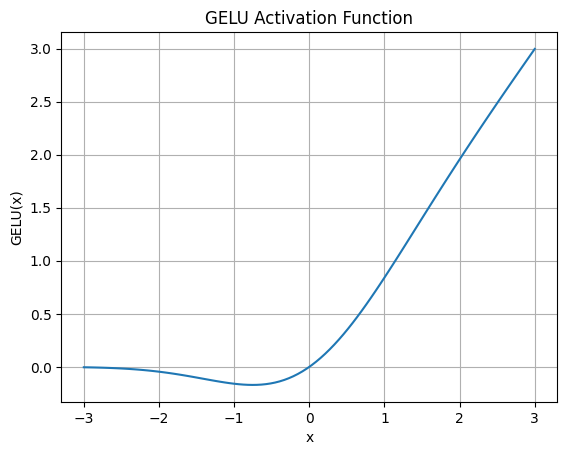

In [23]:
plt.plot(x, res)
plt.xlabel('x')
plt.ylabel('GELU(x)')
plt.title('GELU Activation Function')
plt.grid(True)
plt.show()

In [24]:
class RELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.clamp(x, min=0)

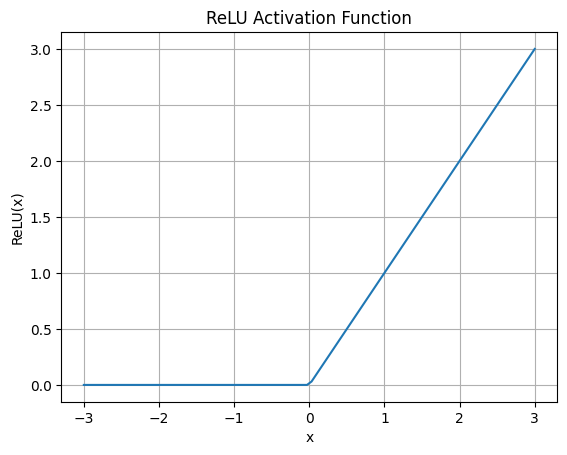

In [27]:
x = np.linspace(-3, 3, 100)
res = np.maximum(0, x)  # NumPy ReLU

plt.plot(x, res)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU Activation Function')
plt.grid(True)
plt.show()

In [28]:
class FeedForward(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.layer1 = nn.Linear(emb_size, 4*emb_size)
        self.gelu = nn.GELU()
        self.layer2 = nn.Linear(4*emb_size, emb_size)

    def forward(self, x):
        return self.layer2(self.gelu(self.layer1(x)))

In [30]:
input = torch.randn(2, 6) 
input

tensor([[-0.7088, -1.1469, -0.1178,  0.4022,  0.5842, -0.1210],
        [ 0.1825, -0.2501, -1.0670,  2.1294, -0.4553,  1.1336]])

In [32]:
ff = FeedForward(6)
ff(input)

tensor([[ 0.0767, -0.1526, -0.1905,  0.1942,  0.2655,  0.1570],
        [ 0.4779, -0.0292, -0.2832,  0.5040,  0.1945,  0.0253]],
       grad_fn=<AddmmBackward0>)